In [76]:
#Import Dependencies
import cv2
import numpy as np
import pandas as pd
import os
import keras
import numpy as np
import imageio
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#Move validation images to training folder
from shutil import copyfile
         
for i in range(1,501):
    newindex = i + 1500
    copyfile("skin/validation_images/validation_img_" + str(i) + ".jpg", "skin/training_images/train_img_" + str(newindex) + ".jpg")
    copyfile("skin/validation_masks/validation_mask_" + str(i) + ".jpg", "skin/training_masks/train_mask_" + str(newindex) + ".jpg")

In [ ]:
#Data Augmentation: Horizontal Flips only
for i in range(1,2001):
    img = cv2.imread('training_images/train_img_' + str(i) + '.jpg')
    mask = cv2.imread('training_masks/train_mask_' + str(i) + '.jpg')
    img = cv2.flip(img, 1)
    mask = cv2.flip(mask, 1)
    cv2.imwrite('training_images/train_img_' + str(i+2000) + '.jpg', img)
    cv2.imwrite('training_masks/train_mask_' + str(i+2000) + '.jpg', mask)    

In [3]:
##Generate list of filenames
train_ids = []
test_ids = []
for i in range(1,len(os.listdir('skin/training_images')) + 1):
    train_ids.append(i)  
    
for i in range(1,len(os.listdir('skin/testing_images')) + 1):
    test_ids.append(i)  

#
print(len(train_ids))
print(len(test_ids))

4000
927


In [4]:
#Define Data Paths
TRAIN_PATH = 'skin/training_images/'
TRAIN_MASK_PATH = 'skin/training_masks/'
TEST_PATH = 'skin/testing_images/'

train_ids2 = next(os.walk(TRAIN_PATH))[2]
mask_ids = next(os.walk(TRAIN_MASK_PATH))[2]
test_ids2 = next(os.walk(TEST_PATH))[2]

In [5]:
#Define Image Sizing
im_width = 256
im_height = 256
border = 5
im_chan = 3

# VGG16-UNET

In [25]:
#CREATE VGG16-UNET MODEL
from keras.applications.vgg16 import VGG16
from keras.layers import Dropout

base_pretrained_model = VGG16(input_shape =  (256,256,3), include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

x = base_pretrained_model.layers[-1].output
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='single_conv')(x)
x = (BatchNormalization())(x)

vggunet_custom = Model(base_pretrained_model.input, x)

for layer in vggunet_custom.layers[:-3]:
    layer.trainable = False

f5 = vggunet_custom.get_layer("block5_conv3").output
f4 = vggunet_custom.get_layer("block4_conv3").output
f3 = vggunet_custom.get_layer("block3_conv3").output
f2 = vggunet_custom.get_layer("block2_conv2").output
f1 = vggunet_custom.get_layer("block1_conv2").output

o = UpSampling2D(size = (2,2))(x)
up6 = Conv2DTranspose(512, 2, activation = 'relu', padding = 'same')(o)
merge6 = concatenate([f5, up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)
o = (BatchNormalization())(conv6)

o = UpSampling2D(size = (2,2))(o)
up6 = Conv2DTranspose(512, 2, activation = 'relu', padding = 'same')(o)
merge6 = concatenate([f4, up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same')(conv6)
o = (BatchNormalization())(conv6)

o = UpSampling2D(size = (2,2))(o)
up6 = Conv2DTranspose(256, 2, activation = 'relu', padding = 'same')(o)
merge6 = concatenate([f3, up6], axis = 3)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv6)
o = (BatchNormalization())(conv6)

o = UpSampling2D(size = (2,2))(o)
up6 = Conv2DTranspose(128, 2, activation = 'relu', padding = 'same')(o)
merge6 = concatenate([f2, up6], axis = 3)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv6)
o = (BatchNormalization())(conv6)

o = UpSampling2D(size = (2,2))(o)
up6 = Conv2DTranspose(64, 2, activation = 'relu', padding = 'same')(o)
merge6 = concatenate([f1, up6], axis = 3)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge6)
conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv6)
o = (BatchNormalization())(conv6)

o = Conv2D(1, (1,1), activation = 'sigmoid', padding = 'same')(o)

vggunet_custom = Model(base_pretrained_model.input, o)

vggunet_custom.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

batch_normalization_22 (BatchNo (None, 64, 64, 256)  1024        conv2d_17[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_19 (UpSampling2D) (None, 128, 128, 256 0           batch_normalization_22[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_41 (Conv2DTran (None, 128, 128, 128 131200      up_sampling2d_19[0][0]           
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 128, 128, 256 0           block2_conv2[0][0]               
                                                                 conv2d_transpose_41[0][0]        
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 128 295040      concatenate_19[0][0]             
__________

In [7]:
#Read images and store into a np array
import sys
from tqdm import tqdm
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize

#train_ids = next(os.walk(train_path+"training_images"))[2]
SIZE=256

# Get and resize train images and masks
X = np.zeros((len(train_ids), SIZE, SIZE, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), SIZE, SIZE, 1), dtype=np.float32)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for i in range(1, len(train_ids) + 1):
    img = imread(TRAIN_PATH + 'train_img_' + str(i) + '.jpg')[:,:,:im_chan]
    x_img = resize(img, (SIZE, SIZE), mode='constant', preserve_range=True)
    
    #normalize image pixels
    X[i-1] = x_img / 255
    
    mask = img_to_array(load_img(TRAIN_MASK_PATH + 'train_mask_' + str(i) + '.jpg', grayscale=True))
    mask = resize(mask, (SIZE, SIZE, 1), mode='constant', preserve_range=True)
    
    #normalize mask pixels
    y[i-1] = mask / 255

print('Done!')


Getting and resizing train images and masks ... 


C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Done!


In [8]:
#Import train_test_split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=42)

In [9]:
#Define our potential loss function and metrics
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

In [26]:
from keras.optimizers import SGD, Adam, Adadelta

#Define callbacks and begin training...
callbacks = [
    EarlyStopping(patience=30, verbose=1),
    ReduceLROnPlateau(patience=8, verbose=1),
    ModelCheckpoint('model-skinsg-vggunet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-7)
vggunet_custom.compile(optimizer=adadelta, loss=bce_dice_loss, metrics=[dice_loss])
vggunet_custom.fit(X_train, y_train, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks, epochs=100)

Train on 3600 samples, validate on 400 samples
Epoch 1/100
1408/3600 [==========>...................] - ETA: 27:59 - loss: 0.0399 - dice_loss: 0.98 - ETA: 16:05 - loss: 0.0405 - dice_loss: 0.98 - ETA: 12:07 - loss: 0.0414 - dice_loss: 0.97 - ETA: 10:07 - loss: 0.0406 - dice_loss: 0.97 - ETA: 8:55 - loss: 0.0406 - dice_loss: 0.9799 - ETA: 8:07 - loss: 0.0413 - dice_loss: 0.979 - ETA: 7:33 - loss: 0.0419 - dice_loss: 0.979 - ETA: 7:06 - loss: 0.0419 - dice_loss: 0.979 - ETA: 6:46 - loss: 0.0414 - dice_loss: 0.979 - ETA: 6:30 - loss: 0.0413 - dice_loss: 0.979 - ETA: 6:16 - loss: 0.0410 - dice_loss: 0.979 - ETA: 6:05 - loss: 0.0408 - dice_loss: 0.979 - ETA: 5:55 - loss: 0.0408 - dice_loss: 0.979 - ETA: 5:47 - loss: 0.0409 - dice_loss: 0.980 - ETA: 5:39 - loss: 0.0413 - dice_loss: 0.979 - ETA: 5:33 - loss: 0.0411 - dice_loss: 0.979 - ETA: 5:27 - loss: 0.0413 - dice_loss: 0.979 - ETA: 5:22 - loss: 0.0413 - dice_loss: 0.979 - ETA: 5:17 - loss: 0.0413 - dice_loss: 0.979 - ETA: 5:13 - loss: 0.0

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0417 - dice_loss: 0.979 - ETA: 4:17 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:17 - loss: 0.0436 - dice_loss: 0.978 - ETA: 4:16 - loss: 0.0444 - dice_loss: 0.978 - ETA: 4:15 - loss: 0.0433 - dice_loss: 0.978 - ETA: 4:15 - loss: 0.0445 - dice_loss: 0.978 - ETA: 4:14 - loss: 0.0444 - dice_loss: 0.978 - ETA: 4:14 - loss: 0.0445 - dice_loss: 0.978 - ETA: 4:13 - loss: 0.0447 - dice_loss: 0.978 - ETA: 4:12 - loss: 0.0442 - dice_loss: 0.978 - ETA: 4:12 - loss: 0.0440 - dice_loss: 0.978 - ETA: 4:11 - loss: 0.0438 - dice_loss: 0.978 - ETA: 4:11 - loss: 0.0437 - dice_loss: 0.978 - ETA: 4:10 - loss: 0.0433 - dice_loss: 0.978 - ETA: 4:10 - loss: 0.0433 - dice_loss: 0.978 - ETA: 4:09 - loss: 0.0430 - dice_loss: 0.978 - ETA: 4:08 - loss: 0.0433 - dice_loss: 0.978 - ETA: 4:08 - loss: 0.0435 - dice_loss: 0.978 - ETA: 4:07 - loss: 0.0437 - dice_loss: 0.978 - ETA: 4:07 - loss: 0.0437 - dice_loss: 0.978 - ETA: 4:06 - loss: 0.0437 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0448 - dice_loss: 0.97 - ETA: 53s - loss: 0.0448 - dice_loss: 0.97 - ETA: 52s - loss: 0.0448 - dice_loss: 0.97 - ETA: 51s - loss: 0.0448 - dice_loss: 0.97 - ETA: 51s - loss: 0.0448 - dice_loss: 0.97 - ETA: 50s - loss: 0.0448 - dice_loss: 0.97 - ETA: 50s - loss: 0.0448 - dice_loss: 0.97 - ETA: 49s - loss: 0.0448 - dice_loss: 0.97 - ETA: 49s - loss: 0.0448 - dice_loss: 0.97 - ETA: 48s - loss: 0.0448 - dice_loss: 0.97 - ETA: 47s - loss: 0.0448 - dice_loss: 0.97 - ETA: 47s - loss: 0.0448 - dice_loss: 0.97 - ETA: 46s - loss: 0.0448 - dice_loss: 0.97 - ETA: 46s - loss: 0.0448 - dice_loss: 0.97 - ETA: 45s - loss: 0.0448 - dice_loss: 0.97 - ETA: 45s - loss: 0.0448 - dice_loss: 0.97 - ETA: 44s - loss: 0.0448 - dice_loss: 0.97 - ETA: 43s - loss: 0.0448 - dice_loss: 0.97 - ETA: 43s - loss: 0.0448 - dice_loss: 0.97 - ETA: 42s - loss: 0.0448 - dice_loss: 0.97 - ETA: 42s - loss: 0.0448 - dice_loss: 0.97 - ETA: 41s - loss: 0.0448 - dice_

1424/3600 [==========>...................] - ETA: 4:19 - loss: 0.0393 - dice_loss: 0.979 - ETA: 4:22 - loss: 0.0408 - dice_loss: 0.979 - ETA: 4:20 - loss: 0.0397 - dice_loss: 0.979 - ETA: 4:20 - loss: 0.0403 - dice_loss: 0.979 - ETA: 4:19 - loss: 0.0405 - dice_loss: 0.979 - ETA: 4:18 - loss: 0.0408 - dice_loss: 0.979 - ETA: 4:17 - loss: 0.0410 - dice_loss: 0.979 - ETA: 4:15 - loss: 0.0418 - dice_loss: 0.979 - ETA: 4:15 - loss: 0.0416 - dice_loss: 0.979 - ETA: 4:14 - loss: 0.0419 - dice_loss: 0.979 - ETA: 4:13 - loss: 0.0415 - dice_loss: 0.979 - ETA: 4:12 - loss: 0.0415 - dice_loss: 0.979 - ETA: 4:11 - loss: 0.0413 - dice_loss: 0.979 - ETA: 4:11 - loss: 0.0414 - dice_loss: 0.979 - ETA: 4:10 - loss: 0.0414 - dice_loss: 0.979 - ETA: 4:09 - loss: 0.0414 - dice_loss: 0.979 - ETA: 4:09 - loss: 0.0417 - dice_loss: 0.979 - ETA: 4:08 - loss: 0.0417 - dice_loss: 0.979 - ETA: 4:07 - loss: 0.0422 - dice_loss: 0.979 - ETA: 4:07 - loss: 0.0422 - dice_loss: 0.979 - ETA: 4:06 - loss: 0.0422 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0432 - dice_loss: 0.97 - ETA: 52s - loss: 0.0432 - dice_loss: 0.97 - ETA: 52s - loss: 0.0432 - dice_loss: 0.97 - ETA: 51s - loss: 0.0432 - dice_loss: 0.97 - ETA: 50s - loss: 0.0432 - dice_loss: 0.97 - ETA: 50s - loss: 0.0432 - dice_loss: 0.97 - ETA: 49s - loss: 0.0432 - dice_loss: 0.97 - ETA: 49s - loss: 0.0432 - dice_loss: 0.97 - ETA: 48s - loss: 0.0433 - dice_loss: 0.97 - ETA: 48s - loss: 0.0433 - dice_loss: 0.97 - ETA: 47s - loss: 0.0433 - dice_loss: 0.97 - ETA: 46s - loss: 0.0433 - dice_loss: 0.97 - ETA: 46s - loss: 0.0433 - dice_loss: 0.97 - ETA: 45s - loss: 0.0433 - dice_loss: 0.97 - ETA: 45s - loss: 0.0433 - dice_loss: 0.97 - ETA: 44s - loss: 0.0433 - dice_loss: 0.97 - ETA: 44s - loss: 0.0433 - dice_loss: 0.97 - ETA: 43s - loss: 0.0433 - dice_loss: 0.97 - ETA: 42s - loss: 0.0433 - dice_loss: 0.97 - ETA: 42s - loss: 0.0433 - dice_loss: 0.97 - ETA: 41s - loss: 0.0433 - dice_loss: 0.97 - ETA: 41s - loss: 0.0433 - dice_

1424/3600 [==========>...................] - ETA: 4:19 - loss: 0.0392 - dice_loss: 0.980 - ETA: 5:59 - loss: 0.0402 - dice_loss: 0.980 - ETA: 5:26 - loss: 0.0397 - dice_loss: 0.980 - ETA: 5:10 - loss: 0.0421 - dice_loss: 0.979 - ETA: 5:00 - loss: 0.0420 - dice_loss: 0.978 - ETA: 4:54 - loss: 0.0408 - dice_loss: 0.979 - ETA: 4:49 - loss: 0.0410 - dice_loss: 0.979 - ETA: 4:45 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:41 - loss: 0.0405 - dice_loss: 0.979 - ETA: 4:37 - loss: 0.0409 - dice_loss: 0.979 - ETA: 4:34 - loss: 0.0415 - dice_loss: 0.979 - ETA: 4:32 - loss: 0.0414 - dice_loss: 0.979 - ETA: 4:30 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:28 - loss: 0.0412 - dice_loss: 0.979 - ETA: 4:26 - loss: 0.0414 - dice_loss: 0.979 - ETA: 4:25 - loss: 0.0412 - dice_loss: 0.979 - ETA: 4:23 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:22 - loss: 0.0409 - dice_loss: 0.979 - ETA: 4:20 - loss: 0.0410 - dice_loss: 0.979 - ETA: 4:19 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:18 - loss: 0.0412 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0415 - dice_loss: 0.97 - ETA: 53s - loss: 0.0415 - dice_loss: 0.97 - ETA: 52s - loss: 0.0415 - dice_loss: 0.97 - ETA: 51s - loss: 0.0415 - dice_loss: 0.97 - ETA: 51s - loss: 0.0415 - dice_loss: 0.97 - ETA: 50s - loss: 0.0415 - dice_loss: 0.97 - ETA: 50s - loss: 0.0415 - dice_loss: 0.97 - ETA: 49s - loss: 0.0415 - dice_loss: 0.97 - ETA: 49s - loss: 0.0416 - dice_loss: 0.97 - ETA: 48s - loss: 0.0416 - dice_loss: 0.97 - ETA: 47s - loss: 0.0416 - dice_loss: 0.97 - ETA: 47s - loss: 0.0416 - dice_loss: 0.97 - ETA: 46s - loss: 0.0416 - dice_loss: 0.97 - ETA: 46s - loss: 0.0416 - dice_loss: 0.97 - ETA: 45s - loss: 0.0416 - dice_loss: 0.97 - ETA: 45s - loss: 0.0416 - dice_loss: 0.97 - ETA: 44s - loss: 0.0416 - dice_loss: 0.97 - ETA: 43s - loss: 0.0416 - dice_loss: 0.97 - ETA: 43s - loss: 0.0416 - dice_loss: 0.97 - ETA: 42s - loss: 0.0416 - dice_loss: 0.97 - ETA: 42s - loss: 0.0416 - dice_loss: 0.97 - ETA: 41s - loss: 0.0416 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0411 - dice_loss: 0.979 - ETA: 4:16 - loss: 0.0396 - dice_loss: 0.980 - ETA: 4:16 - loss: 0.0398 - dice_loss: 0.979 - ETA: 4:15 - loss: 0.0400 - dice_loss: 0.979 - ETA: 4:14 - loss: 0.0402 - dice_loss: 0.980 - ETA: 4:14 - loss: 0.0390 - dice_loss: 0.980 - ETA: 4:13 - loss: 0.0385 - dice_loss: 0.981 - ETA: 4:13 - loss: 0.0382 - dice_loss: 0.981 - ETA: 4:12 - loss: 0.0379 - dice_loss: 0.981 - ETA: 4:12 - loss: 0.0387 - dice_loss: 0.980 - ETA: 4:11 - loss: 0.0395 - dice_loss: 0.980 - ETA: 4:10 - loss: 0.0392 - dice_loss: 0.980 - ETA: 4:10 - loss: 0.0392 - dice_loss: 0.980 - ETA: 4:09 - loss: 0.0391 - dice_loss: 0.980 - ETA: 4:09 - loss: 0.0392 - dice_loss: 0.980 - ETA: 4:08 - loss: 0.0389 - dice_loss: 0.980 - ETA: 4:08 - loss: 0.0389 - dice_loss: 0.980 - ETA: 4:07 - loss: 0.0391 - dice_loss: 0.980 - ETA: 4:06 - loss: 0.0391 - dice_loss: 0.980 - ETA: 4:06 - loss: 0.0393 - dice_loss: 0.980 - ETA: 4:05 - loss: 0.0393 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0399 - dice_loss: 0.98 - ETA: 52s - loss: 0.0399 - dice_loss: 0.98 - ETA: 52s - loss: 0.0399 - dice_loss: 0.98 - ETA: 51s - loss: 0.0399 - dice_loss: 0.98 - ETA: 51s - loss: 0.0399 - dice_loss: 0.98 - ETA: 50s - loss: 0.0399 - dice_loss: 0.98 - ETA: 49s - loss: 0.0399 - dice_loss: 0.98 - ETA: 49s - loss: 0.0399 - dice_loss: 0.98 - ETA: 48s - loss: 0.0399 - dice_loss: 0.98 - ETA: 48s - loss: 0.0399 - dice_loss: 0.98 - ETA: 47s - loss: 0.0399 - dice_loss: 0.98 - ETA: 46s - loss: 0.0399 - dice_loss: 0.98 - ETA: 46s - loss: 0.0399 - dice_loss: 0.98 - ETA: 45s - loss: 0.0399 - dice_loss: 0.98 - ETA: 45s - loss: 0.0399 - dice_loss: 0.98 - ETA: 44s - loss: 0.0399 - dice_loss: 0.98 - ETA: 44s - loss: 0.0399 - dice_loss: 0.98 - ETA: 43s - loss: 0.0399 - dice_loss: 0.98 - ETA: 42s - loss: 0.0399 - dice_loss: 0.98 - ETA: 42s - loss: 0.0399 - dice_loss: 0.98 - ETA: 41s - loss: 0.0399 - dice_loss: 0.98 - ETA: 41s - loss: 0.0399 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0367 - dice_loss: 0.982 - ETA: 4:16 - loss: 0.0375 - dice_loss: 0.981 - ETA: 4:15 - loss: 0.0378 - dice_loss: 0.981 - ETA: 4:15 - loss: 0.0374 - dice_loss: 0.981 - ETA: 4:14 - loss: 0.0374 - dice_loss: 0.981 - ETA: 4:14 - loss: 0.0373 - dice_loss: 0.981 - ETA: 4:13 - loss: 0.0373 - dice_loss: 0.981 - ETA: 4:13 - loss: 0.0376 - dice_loss: 0.981 - ETA: 4:12 - loss: 0.0380 - dice_loss: 0.981 - ETA: 4:11 - loss: 0.0379 - dice_loss: 0.981 - ETA: 4:11 - loss: 0.0377 - dice_loss: 0.981 - ETA: 4:10 - loss: 0.0381 - dice_loss: 0.981 - ETA: 4:10 - loss: 0.0380 - dice_loss: 0.981 - ETA: 4:09 - loss: 0.0378 - dice_loss: 0.981 - ETA: 4:09 - loss: 0.0380 - dice_loss: 0.981 - ETA: 4:08 - loss: 0.0383 - dice_loss: 0.981 - ETA: 4:08 - loss: 0.0382 - dice_loss: 0.981 - ETA: 4:07 - loss: 0.0380 - dice_loss: 0.981 - ETA: 4:06 - loss: 0.0381 - dice_loss: 0.981 - ETA: 4:06 - loss: 0.0381 - dice_loss: 0.981 - ETA: 4:05 - loss: 0.0381 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0375 - dice_loss: 0.98 - ETA: 52s - loss: 0.0375 - dice_loss: 0.98 - ETA: 52s - loss: 0.0375 - dice_loss: 0.98 - ETA: 51s - loss: 0.0375 - dice_loss: 0.98 - ETA: 51s - loss: 0.0375 - dice_loss: 0.98 - ETA: 50s - loss: 0.0375 - dice_loss: 0.98 - ETA: 49s - loss: 0.0375 - dice_loss: 0.98 - ETA: 49s - loss: 0.0375 - dice_loss: 0.98 - ETA: 48s - loss: 0.0375 - dice_loss: 0.98 - ETA: 48s - loss: 0.0375 - dice_loss: 0.98 - ETA: 47s - loss: 0.0375 - dice_loss: 0.98 - ETA: 46s - loss: 0.0375 - dice_loss: 0.98 - ETA: 46s - loss: 0.0375 - dice_loss: 0.98 - ETA: 45s - loss: 0.0375 - dice_loss: 0.98 - ETA: 45s - loss: 0.0375 - dice_loss: 0.98 - ETA: 44s - loss: 0.0375 - dice_loss: 0.98 - ETA: 44s - loss: 0.0375 - dice_loss: 0.98 - ETA: 43s - loss: 0.0375 - dice_loss: 0.98 - ETA: 42s - loss: 0.0375 - dice_loss: 0.98 - ETA: 42s - loss: 0.0375 - dice_loss: 0.98 - ETA: 41s - loss: 0.0375 - dice_loss: 0.98 - ETA: 41s - loss: 0.0375 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0396 - dice_loss: 0.980 - ETA: 4:16 - loss: 0.0379 - dice_loss: 0.981 - ETA: 4:16 - loss: 0.0376 - dice_loss: 0.981 - ETA: 4:15 - loss: 0.0382 - dice_loss: 0.981 - ETA: 4:15 - loss: 0.0379 - dice_loss: 0.981 - ETA: 4:14 - loss: 0.0375 - dice_loss: 0.981 - ETA: 4:13 - loss: 0.0372 - dice_loss: 0.981 - ETA: 4:13 - loss: 0.0370 - dice_loss: 0.981 - ETA: 4:12 - loss: 0.0367 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0369 - dice_loss: 0.981 - ETA: 4:11 - loss: 0.0370 - dice_loss: 0.981 - ETA: 4:11 - loss: 0.0369 - dice_loss: 0.981 - ETA: 4:10 - loss: 0.0369 - dice_loss: 0.981 - ETA: 4:09 - loss: 0.0372 - dice_loss: 0.981 - ETA: 4:09 - loss: 0.0372 - dice_loss: 0.981 - ETA: 4:08 - loss: 0.0370 - dice_loss: 0.981 - ETA: 4:08 - loss: 0.0368 - dice_loss: 0.981 - ETA: 4:07 - loss: 0.0372 - dice_loss: 0.981 - ETA: 4:07 - loss: 0.0370 - dice_loss: 0.981 - ETA: 4:06 - loss: 0.0370 - dice_loss: 0.981 - ETA: 4:05 - loss: 0.0367 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0361 - dice_loss: 0.98 - ETA: 52s - loss: 0.0361 - dice_loss: 0.98 - ETA: 52s - loss: 0.0361 - dice_loss: 0.98 - ETA: 51s - loss: 0.0361 - dice_loss: 0.98 - ETA: 51s - loss: 0.0361 - dice_loss: 0.98 - ETA: 50s - loss: 0.0361 - dice_loss: 0.98 - ETA: 49s - loss: 0.0361 - dice_loss: 0.98 - ETA: 49s - loss: 0.0361 - dice_loss: 0.98 - ETA: 48s - loss: 0.0361 - dice_loss: 0.98 - ETA: 48s - loss: 0.0361 - dice_loss: 0.98 - ETA: 47s - loss: 0.0361 - dice_loss: 0.98 - ETA: 46s - loss: 0.0361 - dice_loss: 0.98 - ETA: 46s - loss: 0.0361 - dice_loss: 0.98 - ETA: 45s - loss: 0.0361 - dice_loss: 0.98 - ETA: 45s - loss: 0.0361 - dice_loss: 0.98 - ETA: 44s - loss: 0.0361 - dice_loss: 0.98 - ETA: 44s - loss: 0.0361 - dice_loss: 0.98 - ETA: 43s - loss: 0.0361 - dice_loss: 0.98 - ETA: 42s - loss: 0.0361 - dice_loss: 0.98 - ETA: 42s - loss: 0.0361 - dice_loss: 0.98 - ETA: 41s - loss: 0.0361 - dice_loss: 0.98 - ETA: 41s - loss: 0.0361 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0354 - dice_loss: 0.983 - ETA: 4:16 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0346 - dice_loss: 0.983 - ETA: 4:15 - loss: 0.0348 - dice_loss: 0.983 - ETA: 4:14 - loss: 0.0344 - dice_loss: 0.983 - ETA: 4:14 - loss: 0.0338 - dice_loss: 0.983 - ETA: 4:14 - loss: 0.0335 - dice_loss: 0.983 - ETA: 4:13 - loss: 0.0339 - dice_loss: 0.983 - ETA: 4:12 - loss: 0.0341 - dice_loss: 0.983 - ETA: 4:12 - loss: 0.0338 - dice_loss: 0.983 - ETA: 4:11 - loss: 0.0339 - dice_loss: 0.983 - ETA: 4:11 - loss: 0.0346 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0345 - dice_loss: 0.983 - ETA: 4:09 - loss: 0.0346 - dice_loss: 0.983 - ETA: 4:09 - loss: 0.0348 - dice_loss: 0.983 - ETA: 4:08 - loss: 0.0354 - dice_loss: 0.982 - ETA: 4:08 - loss: 0.0355 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0358 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0357 - dice_loss: 0.982 - ETA: 4:06 - loss: 0.0357 - dice_loss: 0.982 - ETA: 4:05 - loss: 0.0355 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0354 - dice_loss: 0.98 - ETA: 52s - loss: 0.0354 - dice_loss: 0.98 - ETA: 52s - loss: 0.0354 - dice_loss: 0.98 - ETA: 51s - loss: 0.0353 - dice_loss: 0.98 - ETA: 51s - loss: 0.0354 - dice_loss: 0.98 - ETA: 50s - loss: 0.0354 - dice_loss: 0.98 - ETA: 49s - loss: 0.0354 - dice_loss: 0.98 - ETA: 49s - loss: 0.0354 - dice_loss: 0.98 - ETA: 48s - loss: 0.0354 - dice_loss: 0.98 - ETA: 48s - loss: 0.0354 - dice_loss: 0.98 - ETA: 47s - loss: 0.0354 - dice_loss: 0.98 - ETA: 47s - loss: 0.0354 - dice_loss: 0.98 - ETA: 46s - loss: 0.0354 - dice_loss: 0.98 - ETA: 45s - loss: 0.0354 - dice_loss: 0.98 - ETA: 45s - loss: 0.0354 - dice_loss: 0.98 - ETA: 44s - loss: 0.0354 - dice_loss: 0.98 - ETA: 44s - loss: 0.0354 - dice_loss: 0.98 - ETA: 43s - loss: 0.0354 - dice_loss: 0.98 - ETA: 42s - loss: 0.0354 - dice_loss: 0.98 - ETA: 42s - loss: 0.0354 - dice_loss: 0.98 - ETA: 41s - loss: 0.0354 - dice_loss: 0.98 - ETA: 41s - loss: 0.0354 - dice_

1424/3600 [==========>...................] - ETA: 4:15 - loss: 0.0346 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0351 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0340 - dice_loss: 0.983 - ETA: 4:14 - loss: 0.0348 - dice_loss: 0.982 - ETA: 4:14 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:13 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:13 - loss: 0.0350 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0348 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0352 - dice_loss: 0.982 - ETA: 4:11 - loss: 0.0349 - dice_loss: 0.982 - ETA: 4:11 - loss: 0.0347 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0351 - dice_loss: 0.982 - ETA: 4:09 - loss: 0.0352 - dice_loss: 0.982 - ETA: 4:09 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:08 - loss: 0.0352 - dice_loss: 0.982 - ETA: 4:08 - loss: 0.0351 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:06 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:05 - loss: 0.0351 - dice_loss: 0.982 - ETA: 4:05 - loss: 0.0353 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0351 - dice_loss: 0.98 - ETA: 52s - loss: 0.0351 - dice_loss: 0.98 - ETA: 52s - loss: 0.0351 - dice_loss: 0.98 - ETA: 51s - loss: 0.0351 - dice_loss: 0.98 - ETA: 50s - loss: 0.0351 - dice_loss: 0.98 - ETA: 50s - loss: 0.0351 - dice_loss: 0.98 - ETA: 49s - loss: 0.0351 - dice_loss: 0.98 - ETA: 49s - loss: 0.0351 - dice_loss: 0.98 - ETA: 48s - loss: 0.0351 - dice_loss: 0.98 - ETA: 48s - loss: 0.0351 - dice_loss: 0.98 - ETA: 47s - loss: 0.0351 - dice_loss: 0.98 - ETA: 46s - loss: 0.0351 - dice_loss: 0.98 - ETA: 46s - loss: 0.0351 - dice_loss: 0.98 - ETA: 45s - loss: 0.0351 - dice_loss: 0.98 - ETA: 45s - loss: 0.0351 - dice_loss: 0.98 - ETA: 44s - loss: 0.0351 - dice_loss: 0.98 - ETA: 44s - loss: 0.0351 - dice_loss: 0.98 - ETA: 43s - loss: 0.0351 - dice_loss: 0.98 - ETA: 42s - loss: 0.0351 - dice_loss: 0.98 - ETA: 42s - loss: 0.0351 - dice_loss: 0.98 - ETA: 41s - loss: 0.0351 - dice_loss: 0.98 - ETA: 41s - loss: 0.0351 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0310 - dice_loss: 0.985 - ETA: 4:16 - loss: 0.0354 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0368 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0362 - dice_loss: 0.982 - ETA: 4:15 - loss: 0.0358 - dice_loss: 0.982 - ETA: 4:14 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:13 - loss: 0.0354 - dice_loss: 0.982 - ETA: 4:13 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0353 - dice_loss: 0.982 - ETA: 4:11 - loss: 0.0352 - dice_loss: 0.982 - ETA: 4:11 - loss: 0.0350 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0350 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0350 - dice_loss: 0.982 - ETA: 4:09 - loss: 0.0349 - dice_loss: 0.983 - ETA: 4:08 - loss: 0.0347 - dice_loss: 0.983 - ETA: 4:08 - loss: 0.0346 - dice_loss: 0.983 - ETA: 4:07 - loss: 0.0349 - dice_loss: 0.983 - ETA: 4:07 - loss: 0.0350 - dice_loss: 0.983 - ETA: 4:06 - loss: 0.0349 - dice_loss: 0.983 - ETA: 4:06 - loss: 0.0350 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0346 - dice_loss: 0.98 - ETA: 52s - loss: 0.0346 - dice_loss: 0.98 - ETA: 52s - loss: 0.0346 - dice_loss: 0.98 - ETA: 51s - loss: 0.0346 - dice_loss: 0.98 - ETA: 51s - loss: 0.0346 - dice_loss: 0.98 - ETA: 50s - loss: 0.0346 - dice_loss: 0.98 - ETA: 49s - loss: 0.0346 - dice_loss: 0.98 - ETA: 49s - loss: 0.0346 - dice_loss: 0.98 - ETA: 48s - loss: 0.0346 - dice_loss: 0.98 - ETA: 48s - loss: 0.0346 - dice_loss: 0.98 - ETA: 47s - loss: 0.0346 - dice_loss: 0.98 - ETA: 47s - loss: 0.0346 - dice_loss: 0.98 - ETA: 46s - loss: 0.0346 - dice_loss: 0.98 - ETA: 45s - loss: 0.0346 - dice_loss: 0.98 - ETA: 45s - loss: 0.0346 - dice_loss: 0.98 - ETA: 44s - loss: 0.0346 - dice_loss: 0.98 - ETA: 44s - loss: 0.0346 - dice_loss: 0.98 - ETA: 43s - loss: 0.0346 - dice_loss: 0.98 - ETA: 43s - loss: 0.0346 - dice_loss: 0.98 - ETA: 42s - loss: 0.0346 - dice_loss: 0.98 - ETA: 41s - loss: 0.0346 - dice_loss: 0.98 - ETA: 41s - loss: 0.0346 - dice_

1424/3600 [==========>...................] - ETA: 4:16 - loss: 0.0339 - dice_loss: 0.983 - ETA: 4:16 - loss: 0.0355 - dice_loss: 0.983 - ETA: 4:15 - loss: 0.0347 - dice_loss: 0.983 - ETA: 4:15 - loss: 0.0362 - dice_loss: 0.982 - ETA: 4:14 - loss: 0.0359 - dice_loss: 0.982 - ETA: 4:14 - loss: 0.0354 - dice_loss: 0.983 - ETA: 4:13 - loss: 0.0355 - dice_loss: 0.983 - ETA: 4:13 - loss: 0.0358 - dice_loss: 0.982 - ETA: 4:12 - loss: 0.0355 - dice_loss: 0.983 - ETA: 4:12 - loss: 0.0351 - dice_loss: 0.983 - ETA: 4:11 - loss: 0.0353 - dice_loss: 0.983 - ETA: 4:11 - loss: 0.0357 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0356 - dice_loss: 0.983 - ETA: 4:10 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:09 - loss: 0.0358 - dice_loss: 0.982 - ETA: 4:08 - loss: 0.0359 - dice_loss: 0.982 - ETA: 4:08 - loss: 0.0357 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0356 - dice_loss: 0.982 - ETA: 4:07 - loss: 0.0354 - dice_loss: 0.982 - ETA: 4:06 - loss: 0.0352 - dice_loss: 0.982 - ETA: 4:06 - loss: 0.0351 - dice_los

3600/3600 [==============================] - ETA: 53s - loss: 0.0346 - dice_loss: 0.98 - ETA: 52s - loss: 0.0346 - dice_loss: 0.98 - ETA: 52s - loss: 0.0346 - dice_loss: 0.98 - ETA: 51s - loss: 0.0346 - dice_loss: 0.98 - ETA: 51s - loss: 0.0345 - dice_loss: 0.98 - ETA: 50s - loss: 0.0346 - dice_loss: 0.98 - ETA: 49s - loss: 0.0346 - dice_loss: 0.98 - ETA: 49s - loss: 0.0346 - dice_loss: 0.98 - ETA: 48s - loss: 0.0346 - dice_loss: 0.98 - ETA: 48s - loss: 0.0346 - dice_loss: 0.98 - ETA: 47s - loss: 0.0346 - dice_loss: 0.98 - ETA: 47s - loss: 0.0346 - dice_loss: 0.98 - ETA: 46s - loss: 0.0345 - dice_loss: 0.98 - ETA: 45s - loss: 0.0345 - dice_loss: 0.98 - ETA: 45s - loss: 0.0345 - dice_loss: 0.98 - ETA: 44s - loss: 0.0345 - dice_loss: 0.98 - ETA: 44s - loss: 0.0345 - dice_loss: 0.98 - ETA: 43s - loss: 0.0345 - dice_loss: 0.98 - ETA: 43s - loss: 0.0345 - dice_loss: 0.98 - ETA: 42s - loss: 0.0345 - dice_loss: 0.98 - ETA: 41s - loss: 0.0345 - dice_loss: 0.98 - ETA: 41s - loss: 0.0345 - dice_

KeyboardInterrupt: 

# Testing

In [26]:
#Load model's saved weights
vggunet_custom.load_weights('model-skinsg-vggunet.h5')

In [30]:
#Evaluate the model
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-7)
vggunet_custom.compile(optimizer=SGD(lr=1e-2, momentum=0.99, decay=0.0005), loss="binary_crossentropy", metrics=[dice_loss])
vggunet_custom.evaluate(X_valid, y_valid)

400/400 [==============================] - ETA: 16 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s 27ms/step


[0.07511553943157195, 0.9521177291870118]

In [33]:
#Read testing images and store into a np array.
X_test = np.zeros((len(test_ids), 256, 256, im_chan), dtype=np.float32)
sizes_test = []

print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids2), total=len(test_ids2)):
    path = TEST_PATH + id_
    img = imread(path)[:,:,:im_chan]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (256, 256), mode='constant', preserve_range=True)
    X_test[n] = img / 255

print('Done!')

Getting and resizing test images ... 


100%|████████████████████████████████████████| 927/927 [00:10<00:00, 88.66it/s]


Done!


In [64]:
#Make predictions and remove any uncertain predictions in masks
preds_test = vggunet_custom.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)



927/927 [==============================] - ETA: 24 - ETA: 22 - ETA: 21 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 17 - ETA: 16 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 11 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 24s 26ms/step


In [24]:
#Save masks to a directory for RLE
import scipy.misc
    
for n, id_ in tqdm(enumerate(test_ids2), total=len(test_ids2)):
    img = resize(np.squeeze(preds_test_t[n]), (sizes_test[n][0], sizes_test[n][1]), mode='constant')
    last = id_.split('_')[2]
    scipy.misc.imsave('skin/test_masks/test_mask_' + last , img)

  0%|                                                  | 0/927 [00:00<?, ?it/s]C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  
100%|███████████████████████████████████████| 927/927 [00:06<00:00, 144.43it/s]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.transform import resize
from skimage.io import imread
%matplotlib inline  

# encoding function
# based on the implementation: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python/code
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [25]:
# (* update) the input_path using your folder path
input_path = './skin/test_masks'

# get a sorted list of all mask filenames in the folder
masks = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
masks = sorted(masks, key=lambda s:int(s.split('_')[2].split('.')[0]))

# encode all masks
encodings = []
for file in masks:
    mask = imread(os.path.join(input_path, file))
    #img_size =10
    #mask = resize(mask, (img_size, img_size), mode='constant', preserve_range=True)
    mask = np.array(mask, dtype=np.uint8)
    mask = np.round(mask/255)
    encodings.append(rle_encoding(mask))


# (** update) the path where to save the submission csv file
sub = pd.DataFrame()
sub['ImageId'] = pd.Series(masks).apply(lambda x: os.path.splitext(x)[0])
sub['EncodedPixels'] = pd.Series(encodings).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv(os.path.join('.', 'skin/vgg16unet_t2.csv'), index=False)

In [109]:
#Helper function to visualize image and masks
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    mask2 = resize(mask, (256,256,3))
    axarr[1].imshow(mask2)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

C:\Users\user\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


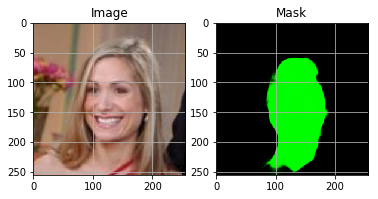

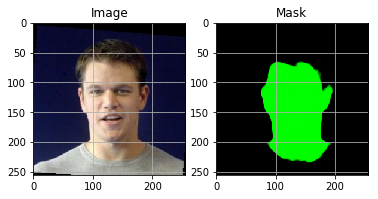

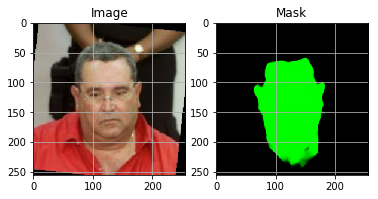

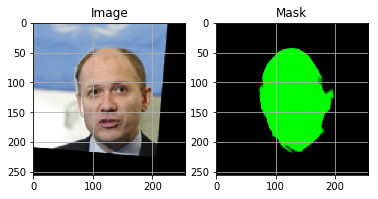

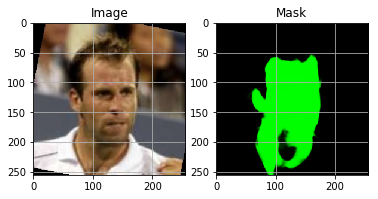

In [110]:
#masks look good!
for i in range(5):
    plot2x2Array(X_test[i], preds_test[i])

In [114]:
import matplotlib.pyplot as plt
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images

In [116]:
ix = random.randint(0, 80)
imshow(np.squeeze(X_test[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 0